# Spark Funds assignment

This notebook holds the steps to anayze the areas for the funding from spark Funds. I have tried to make this as generic as possible within the time available.This should work on any new set of data which has the same format (input format of the files).

### 1 - Load the data file for the companies and rounds to identify the key properties of this data as part of the checkpoint 1

In [1]:
#load the data frame with the files for companies and rounds
import pandas as pd
import numpy as np

# reading a CSV file as a dataframe
df_companies = pd.read_csv("companies.txt",delimiter="\t",encoding='ISO-8859-1')
df_rounds = pd.read_csv("rounds2.csv",encoding='ISO-8859-1')

#constant values
lower_limit_funding = 5000000
upper_limit_funding = 15000000
#as per the scenario provided in the problem statement
funding_types_considered = ['venture','angel','seed','private_equity']

web_scrapping = "https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language"


In [2]:
# Unique companies int the round dataset
list_rounds = list(df_rounds['company_permalink'].unique())
print (len(list_rounds))

90247


In [3]:
# Unique companies int the companies dataset
list_companies = list(df_companies['permalink'].unique())
print (len(list_companies))

66368


### 2- Merge the two dataframe into a master data frame

- Use the inner join from the rounds dataframe to merge the companies frame
- Convert the values in the dataforms to lower case to ensure that the merge happens

In [4]:
df_companies = df_companies.applymap(lambda x:x.lower() if type(x) == str else x)

In [5]:
df_rounds = df_rounds.applymap(lambda x:x.lower() if type(x) == str else x)

Merge the dataform for companies and rounds

In [6]:
master_df = pd.merge(df_rounds, df_companies, how='inner', left_on='company_permalink' ,right_on='permalink')

In [7]:
master_df.shape

(114942, 16)

In [8]:
df_companies.shape

(66368, 10)

In [9]:
df_rounds.shape

(114949, 6)

## Check Point 2 - Investment type analysis
- To find the most representitative values for each type of investment , do a groupby and find the mean of each group which will provide the average for that type

In [10]:
df_master_fundingtype = master_df.groupby(['funding_round_type'],as_index=False).mean()

In [11]:
pd.options.display.float_format = '{:,.4f}'.format
df_master_fundingtype.head(20)

,funding_round_type,raised_amount_usd
0,angel,"958,694.4698"
1,convertible_note,"1,453,438.5432"
2,debt_financing,"17,043,526.0230"
3,equity_crowdfunding,"538,368.2109"
4,grant,"4,300,576.3395"
5,non_equity_assistance,"411,203.0548"
6,post_ipo_debt,"168,704,571.8224"
7,post_ipo_equity,"82,182,493.8710"
8,private_equity,"73,308,593.0294"
9,product_crowdfunding,"1,363,131.0699"


In [12]:
# Top Funding type between 5 MUSd and 15MUSD
funding_type = df_master_fundingtype.loc[df_master_fundingtype["raised_amount_usd"]\
                                         .astype(int)\
                                         .between(lower_limit_funding,upper_limit_funding),:]
print (funding_type.iloc[0,0])

venture


## ```` Funding type details ````
- ```` Average funding amount of venture type - 11748949.1295 ````
- ```` Average funding amount of angel type -  958694.4698 ````
- ```` Average funding amount of seed type - 719779.6202 ````
- ```` Average funding amount of private equity type - 73308593.0294 ````
- ```` Considering that Spark Funds wants to invest between 5 to 15 million USD per  investment round, which investment type is the most suitable for them? - Venture Type ````

## Checkpoint 3 - Country Analysis
- Spark Funds wants to see the top nine countries which have received the highest total funding (across ALL sectors for the chosen investment type) which is a Venture type
- For the chosen investment type, make a data frame named df_countries_top9 with the top nine countries (based on the total investment amount each country has received)

#### Filter the data for the funding type as ````Venture```` and then group by the countries since ````Venture```` is the preferred funding type for Spark funds

In [13]:
#funding_type.iloc[0,0] holds the value of the appropriate funding from the above sections
df_allventure_countries = master_df.loc[master_df['funding_round_type'] == funding_type.iloc[0,0],:]

#### Create a new dataframe which holds the countries and the aggregated funding values for that country

In [14]:
pd.options.display.float_format = '{:,.4f}'.format

In [15]:
df_countries_top9 = df_allventure_countries.groupby(['country_code'],as_index=False).sum().sort_values(by= 'raised_amount_usd', ascending= False).head(9)

In [16]:
df_countries_top9

,country_code,raised_amount_usd
100,usa,"422,510,842,796.0000"
16,chn,"39,835,418,773.0000"
31,gbr,"20,245,627,416.0000"
41,ind,"14,391,858,718.0000"
13,can,"9,583,332,317.0000"
30,fra,"7,259,536,732.0000"
44,isr,"6,907,514,579.0000"
23,deu,"6,346,959,822.0000"
47,jpn,"3,363,676,611.0000"


In [17]:
#Create a list of top9 countries from the data frame. This is needed to identify the english speaking countries using web scrapping
lst_top9 = df_countries_top9['country_code'].tolist()
print (lst_top9)

['usa', 'chn', 'gbr', 'ind', 'can', 'fra', 'isr', 'deu', 'jpn']


#### Identify the top 3  english speaking countries using webscrapping 

In [18]:
#webscappring the wikipedia link to identify the top 3 english speaking countries
import requests 
from bs4 import BeautifulSoup 
  
wiki_URL = web_scrapping
content_wiki = requests.get(wiki_URL) 
  
bs = BeautifulSoup(content_wiki.content, 'html5lib') 
all_tables = bs.find_all('table',{'class': 'wikitable sortable'})
lst_top3 = []
for tbls in all_tables:
    tds = tbls.findAll('td')
    for i in range(len(lst_top9)):
        for td in tds:
            if ((td.text.find(lst_top9[i].upper()) > -1) & (len(lst_top3) < 3)):
                lst_top3.append(lst_top9[i].upper()) 
print (lst_top3)
                

['USA', 'GBR', 'IND']


## ``` Top 3 countries for investment are ```
- ```` 1-USA ````
- ```` 2- GBR ````
- ```` 3-India ````
- ``` China is not considered since it does not have English as the official language ``` 

## Checkpoint 4 - Sector Analysis
Steps -
- Load the mapping .csv into a data frame.
- Correct the data in the category_list of the mapping dataframe. there are some junk values such as 'A0nalytics' etc where 0 represents 'na'. this needs to be corrected in the sheet before the merge is done
- Add the primary sector column in the master DataFrame and extract the primary sector information from the catergory list by splitting the values and extracting the first value.
- Create the Sector information as a column in the master frame by using the mapping sheet

In [19]:
#Load the Mapping csv to DF
df_mapping_raw = pd.read_csv("mapping.csv",encoding='ISO-8859-1')

In [20]:
# Since there are some junk values such as 'A0lytics' etc in the mapping sheet , this has been corrected to the correct format in the subsequent steps
df_mapping_raw.category_list = df_mapping_raw.category_list.apply(lambda x: str(x).replace("0","na"))

In [21]:
#Extract the primary sector values and add as a column
master_df['Primary_sector'] = master_df.category_list.str.split('|',expand=True)[0]

In [22]:
#Create a new dataframe and use melt function to refomat the mapping dataframe in the usable form
df_mapping_transposed = pd.melt(df_mapping_raw, id_vars=['category_list'],var_name="main_sector", value_name='value')

In [23]:
### create the new dataframe which only holds the mainsector(8 sectors) for each category_list 
df_mapping = df_mapping_transposed.loc[(df_mapping_transposed['value'] == 1),['category_list' ,'main_sector']]
# convert the category_list to lower case since the 'primary sector' is in lower
df_mapping = df_mapping.applymap(lambda x:x.lower() if type(x) == str else x)

In [24]:
## Add a new column in the master dataframe to include the 'main sector' (one of the 8 sectors listed in the mappings csv)
## This column will only hold the main sector for the 'Primary sector' value for each company
master_df = pd.merge(master_df, df_mapping, how='left', left_on='Primary_sector' ,right_on='category_list' )

## Checkpoint 5 - Sector Analysis-2
#### Main sector analysis


In [25]:
### Create 3 dataframes to hold the relevant data for each country - c1,c2,c3 top 3 english speaking country
### Hold records where investment is between 5 and 15 million
## funding_type.iloc[0,0] holds the appropriate funding value from the above sections
df_d1 = master_df.loc[(master_df['country_code'] == lst_top3[0].lower()) \
                & (master_df['funding_round_type'] == funding_type.iloc[0,0]) \
                & (master_df['raised_amount_usd'] > lower_limit_funding) \
                & (master_df['raised_amount_usd'] < upper_limit_funding)]

df_d2 = master_df.loc[(master_df['country_code'] == lst_top3[1].lower()) \
                & (master_df['funding_round_type'] == funding_type.iloc[0,0]) \
                & (master_df['raised_amount_usd'] > lower_limit_funding) \
                & (master_df['raised_amount_usd'] < upper_limit_funding)]

df_d3 = master_df.loc[(master_df['country_code'] == lst_top3[2].lower())  \
                & (master_df['funding_round_type'] == funding_type.iloc[0,0]) \
                & (master_df['raised_amount_usd'] > lower_limit_funding) \
                & (master_df['raised_amount_usd'] < upper_limit_funding)]


#### Get the count of investments for each of the 8 main sector for each of the 3 countries

In [26]:
#Identify top sectors in country-1
#df_c1_mainsector will contain the information on the count and amount of funding for each country. The data is filtered based on the funding type of Venture and range between 5 and 15 MUSD
df_c1_mainsector = df_d1.groupby('main_sector',as_index=False).sum()
df_c1_mainsector["Main_Sector"] = df_c1_mainsector["main_sector"]
df_c1_mainsector.set_index('main_sector',inplace=True)
df_c1_mainsector['CountOfInvestments'] = df_d1.groupby('main_sector').raised_amount_usd.count()
lst_c1_top3sectors = df_c1_mainsector.sort_values('CountOfInvestments', ascending=False)["Main_Sector"].tolist()
df_c1_mainsector.sort_values('CountOfInvestments', ascending=False)

,raised_amount_usd,Main_Sector,CountOfInvestments
main_sector,,,
others,"21,736,007,002.0000",others,2423
"social, finance, analytics, advertising","19,397,376,964.0000","social, finance, analytics, advertising",2216
cleantech / semiconductors,"18,148,430,822.0000",cleantech / semiconductors,1991
"news, search and messaging","11,231,567,428.0000","news, search and messaging",1281
health,"6,866,859,357.0000",health,760
manufacturing,"6,228,553,378.0000",manufacturing,691
entertainment,"4,119,197,982.0000",entertainment,479
automotive & sports,"1,269,104,361.0000",automotive & sports,142


In [27]:
#lst_c1_top3sectors will be used for plotting as the sectors will not be hardcoded
print (lst_c1_top3sectors)

['others', 'social, finance, analytics, advertising', 'cleantech / semiconductors', 'news, search and messaging', 'health', 'manufacturing', 'entertainment', 'automotive & sports']


In [28]:
# Total investments count and value in Country-1
df_c1_mainsector.sum()

raised_amount_usd                                   88,997,097,294.0000
Main_Sector           automotive & sportscleantech / semiconductorse...
CountOfInvestments                                                 9983
dtype: object

In [29]:
#Identify top sectors in country-2
#df_c2_mainsector will contain the information on the count and amount of funding for each country. The data is filtered based on the funding type of Venture and range between 5 and 15 MUSD
df_c2_mainsector = df_d2.groupby('main_sector',as_index=False).sum()
df_c2_mainsector["Main_Sector"] = df_c2_mainsector["main_sector"]
df_c2_mainsector.set_index('main_sector',inplace=True)
df_c2_mainsector['CountOfInvestments'] = df_d2.groupby('main_sector').raised_amount_usd.count()
lst_c2_top3sectors = df_c2_mainsector.sort_values('CountOfInvestments', ascending=False)["Main_Sector"].tolist()
df_c2_mainsector.sort_values('CountOfInvestments', ascending=False)

,raised_amount_usd,Main_Sector,CountOfInvestments
main_sector,,,
others,"1,123,624,289.0000",others,129
cleantech / semiconductors,"1,123,990,056.0000",cleantech / semiconductors,126
"social, finance, analytics, advertising","974,404,014.0000","social, finance, analytics, advertising",118
"news, search and messaging","565,746,235.0000","news, search and messaging",65
entertainment,"422,784,687.0000",entertainment,48
manufacturing,"331,940,335.0000",manufacturing,38
health,"209,537,510.0000",health,23
automotive & sports,"137,051,565.0000",automotive & sports,14


In [30]:
#lst_c2_top3sectors will be used for plotting as the sectors will not be hardcoded. This is an ordered list
print (lst_c2_top3sectors)

['others', 'cleantech / semiconductors', 'social, finance, analytics, advertising', 'news, search and messaging', 'entertainment', 'manufacturing', 'health', 'automotive & sports']


In [31]:
# Total investments count and value in country-2
df_c2_mainsector.sum()

raised_amount_usd                                    4,889,078,691.0000
Main_Sector           automotive & sportscleantech / semiconductorse...
CountOfInvestments                                                  561
dtype: object

In [32]:
#Identify top sectors in country 3
#df_c3_mainsector will contain the information on the count and amount of funding for each country. The data is filtered based on the funding type of Venture and range between 5 and 15 MUSD
df_c3_mainsector = df_d3.groupby('main_sector',as_index=False).sum()
df_c3_mainsector["Main_Sector"] = df_c3_mainsector["main_sector"]
df_c3_mainsector.set_index('main_sector',inplace=True)
df_c3_mainsector['CountOfInvestments'] = df_d3.groupby('main_sector').raised_amount_usd.count()
lst_c3_top3sectors = df_c3_mainsector.sort_values('CountOfInvestments', ascending=False)["Main_Sector"].tolist()
df_c3_mainsector.sort_values('CountOfInvestments', ascending=False)

,raised_amount_usd,Main_Sector,CountOfInvestments
main_sector,,,
others,"703,409,507.0000",others,78
"social, finance, analytics, advertising","385,549,550.0000","social, finance, analytics, advertising",45
"news, search and messaging","368,834,545.0000","news, search and messaging",41
entertainment,"200,830,000.0000",entertainment,23
manufacturing,"165,900,000.0000",manufacturing,18
health,"157,740,000.0000",health,17
cleantech / semiconductors,"125,380,000.0000",cleantech / semiconductors,14
automotive & sports,"66,900,000.0000",automotive & sports,7


In [33]:
#lst_c3_top3sectors will be used for plotting as the sectors will not be hardcoded. This is an ordered list
print (lst_c3_top3sectors)

['others', 'social, finance, analytics, advertising', 'news, search and messaging', 'entertainment', 'manufacturing', 'health', 'cleantech / semiconductors', 'automotive & sports']


In [34]:
# Total investments count and value in country 3
df_c3_mainsector.sum()

raised_amount_usd                                    2,174,543,602.0000
Main_Sector           automotive & sportscleantech / semiconductorse...
CountOfInvestments                                                  243
dtype: object

### ```` Sector Analysis in the top 3 countries ````
- ```` Top 3 sectors in USA - 1-others ,2-social, finance, analytics, advertising, 3-cleantech / semiconductors ````
- ```` Top 3 sectors in GBR - 1-others ,2-cleantech / semiconductors, 3-social, finance, analytics, advertising ````
- ```` Top 3 sectors in IND - 1-others ,2-social, finance, analytics, advertising ,3-news, search and messaging ````

#### Identify the top companies in the top 3 sectors across the top 3 english speaking companies

In [35]:
#Country 1 
#lst_top3[0].lower() holds the country -1
#funding_type.iloc[0,0] holds the funding type
master_df.loc[(master_df['country_code'] == lst_top3[0].lower()) \
              & ((master_df['main_sector'] == lst_c1_top3sectors[0]) \
                 | (master_df['main_sector'] == lst_c1_top3sectors[1]) \
                 | (master_df['main_sector'] == lst_c1_top3sectors[2])) \
              & (master_df['funding_round_type'] == funding_type.iloc[0,0])] \
.groupby(['country_code','company_permalink','main_sector']).sum().sort_values('raised_amount_usd' ,ascending=False).head(10)

raised_amount_usd
country_code company_permalink               main_sector                                                
usa          /organization/freescale         cleantech / semiconductors              17,600,000,000.0000
             /organization/mediavast         social, finance, analytics, advertising  4,715,000,000.0000
             /organization/social-finance    others                                   1,365,199,900.0000
             /organization/snapchat          others                                   1,165,100,000.0000
             /organization/juno-therapeutics cleantech / semiconductors               1,159,803,496.0000
             /organization/groupon           social, finance, analytics, advertising  1,136,000,000.0000
             /organization/cloudera          social, finance, analytics, advertising  1,041,000,000.0000
             /organization/wework            social, finance, analytics, advertising    995,934,331.0000
             /organization/zynga             social, finance, analytics, advertising    866,550,786.0000
             /organization/livingsocial      others                                     818,225,039.0000

In [36]:
#Country 2 
#lst_top3[1].lower() holds the country -2
#funding_type.iloc[0,0] holds the funding type
master_df.loc[(master_df['country_code'] == lst_top3[1].lower()) \
              & ((master_df['main_sector'] == lst_c2_top3sectors[0]) \
                 | (master_df['main_sector'] == lst_c2_top3sectors[1]) \
                 | (master_df['main_sector'] == lst_c2_top3sectors[2])) \
              & (master_df['funding_round_type'] == funding_type.iloc[0,0])] \
.groupby(['country_code','company_permalink','main_sector']).sum().sort_values('raised_amount_usd' ,ascending=False).head(10)

raised_amount_usd
country_code company_permalink               main_sector                                               
gbr          /organization/oneweb            others                                    500,000,000.0000
             /organization/immunocore        cleantech / semiconductors                320,000,000.0000
             /organization/farfetch          others                                    194,500,000.0000
             /organization/powa-technologies social, finance, analytics, advertising   176,700,000.0000
             /organization/borro             social, finance, analytics, advertising   171,572,758.0000
             /organization/reneuron-group    cleantech / semiconductors                150,859,892.0000
             /organization/liquid-telecom    others                                    150,000,000.0000
             /organization/worldremit        social, finance, analytics, advertising   147,109,000.0000
             /organization/wonga             social, finance, analytics, advertising   145,393,366.0000
             /organization/circassia         cleantech / semiconductors                144,630,999.0000

In [37]:
#Country 3 
#lst_top3[2].lower() holds the country -3
#funding_type.iloc[0,0] holds the funding type
master_df.loc[(master_df['country_code'] == lst_top3[2].lower()) \
              & ((master_df['main_sector'] == lst_c3_top3sectors[0]) \
                 | (master_df['main_sector'] == lst_c3_top3sectors[1]) \
                 | (master_df['main_sector'] == lst_c3_top3sectors[2])) \
              & (master_df['funding_round_type'] == funding_type.iloc[0,0])] \
.groupby(['country_code','company_permalink','main_sector']).sum().sort_values('raised_amount_usd' ,ascending=False).head(10)

raised_amount_usd
country_code company_permalink               main_sector                                               
ind          /organization/flipkart          others                                  2,451,000,000.0000
             /organization/quikr-india       news, search and messaging                346,000,000.0000
             /organization/snapdeal          others                                    310,699,998.0000
             /organization/tata-teleservices others                                    212,000,000.0000
             /organization/myntra            others                                    158,750,000.0000
             /organization/shopclues-com     social, finance, analytics, advertising   129,000,000.0000
             /organization/pepperfry-com     others                                    128,000,000.0000
             /organization/delhivery         others                                    127,500,000.0000
             /organization/oyo-rooms         others                                    125,000,000.0000
             /organization/freecharge        news, search and messaging                113,000,000.0000

## Checkpoint 6 - Plots
- Create the master dataframe which only has investments of the type venture, seed, angel and private equity since only these are considered for analysis. Use this dataframe for the first plot.

In [38]:
import matplotlib.pyplot as plt

# the commonly used alias for seaborn is sns
import seaborn as sns

# set a seaborn style of your taste
sns.set_style("whitegrid")

### Plot 1
Box plot which shows the funding across the categories - Venture, seed, angel and private equity. The mean in the box plot is the average funding. This  considers all the investments and is ````not```` limited to cases where the funding is between 5 and 15 million USD

In [39]:
df_master_selectedFundingTypes = master_df.loc[(master_df.funding_round_type == funding_types_considered[0]) \
                                            | (master_df.funding_round_type == funding_types_considered[1]) \
                                            | (master_df.funding_round_type == funding_types_considered[2]) \
                                            | (master_df.funding_round_type == funding_types_considered[3])]
#set the value in MUsd
df_master_selectedFundingTypes["raised_amount_musd"] = df_master_selectedFundingTypes["raised_amount_usd"] / 1000000 


C:\Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
df_master_selectedFundingTypes.groupby("funding_round_type").describe()

raised_amount_usd                                          \
                               count            mean              std    min   
funding_round_type                                                             
angel                     4,860.0000    958,694.4698   7,404,397.1221 0.0000   
private_equity            1,936.0000 73,308,593.0294 198,113,458.4137 0.0000   
seed                     23,602.0000    719,779.6202   2,221,772.0449 0.0000   
venture                  50,228.0000 11,748,949.1295  86,352,066.5580 0.0000   

                                                                   \
                              25%             50%             75%   
funding_round_type                                                  
angel                150,000.0000    400,000.0000  1,000,000.0000   
private_equity     5,000,000.0000 20,000,000.0000 75,000,000.0000   
seed                  55,000.0000    275,000.0000  1,000,000.0000   
venture            1,600,901.7500  5,000,000.0000 12,000,000.0000   

                                       raised_amount_musd                   \
                                   max              count    mean      std   
funding_round_type                                                           
angel                 494,511,992.0000         4,860.0000  0.9587   7.4044   
private_equity      4,745,460,219.0000         1,936.0000 73.3086 198.1135   
seed                  200,000,000.0000        23,602.0000  0.7198   2.2218   
venture            17,600,000,000.0000        50,228.0000 11.7489  86.3521   

                                                              
                      min    25%     50%     75%         max  
funding_round_type                                            
angel              0.0000 0.1500  0.4000  1.0000    494.5120  
private_equity     0.0000 5.0000 20.0000 75.0000  4,745.4602  
seed               0.0000 0.0550  0.2750  1.0000    200.0000  
venture            0.0000 1.6009  5.0000 12.0000 17,600.0000

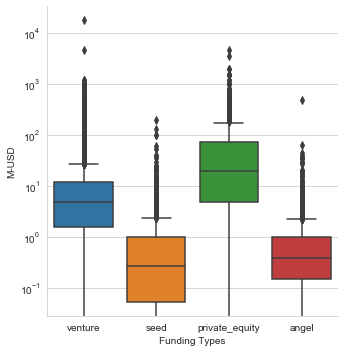

<Figure size 3600x3600 with 0 Axes>

In [41]:
sns.catplot(x="funding_round_type", y="raised_amount_musd" , kind='box' , data=df_master_selectedFundingTypes)
plt.yscale('log')
plt.xlabel("Funding Types")
plt.ylabel("M-USD")
plt.figure(figsize=(50,50))
plt.show()

### Plot2
#### Amount of funding (Venture) recieved for the top 9 countries
This  considers all the investments and is ````not```` limited to cases where the funding is between 5 and 15 million USD

In [42]:
df_temp_country = df_allventure_countries.groupby(['country_code',], as_index=False).agg('sum').sort_values('raised_amount_usd', ascending=False).head(9)
df_temp_country ['raised_amount_Musd'] = df_temp_country ['raised_amount_usd'] /1000000
df_temp_country ['country_code'] = df_temp_country ['country_code'].apply(lambda x: x.upper())

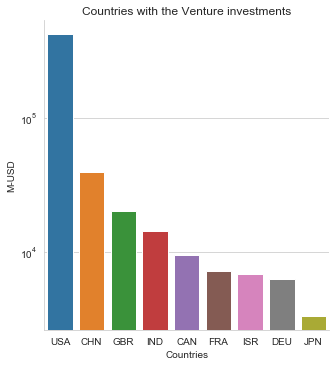

<Figure size 3600x3600 with 0 Axes>

In [43]:
sns.catplot(x="country_code", y="raised_amount_Musd", kind='bar', data=df_temp_country)
plt.title('Countries with the Venture investments')
plt.yscale('log')
plt.xlabel("Countries")
plt.ylabel("M-USD")
plt.figure(figsize=(50,50))
plt.show()

### Plot 3
#### For Venture funds , this shows the numbers of investments across top3 secotors of top 3 countries
This  considers all the investments and is ````limited ````to cases where the funding is between 5 and 15 million USD

In [44]:
## data related to top 3 countries (USA, GBR and India - China excluded since it is not a english speaking country)
# funding_type.iloc[0,0] holds the appropriate funding type (venture) from the above sections
# lst_top3 is the list that holds the top 3 english speaking countries for analysis
df_3country_plot = master_df.loc[(master_df.funding_round_type == funding_type.iloc[0,0]) 
                                 & ((df_allventure_countries['country_code'] == lst_top3[0].lower()) 
                                    | (df_allventure_countries['country_code'] == lst_top3[1].lower()) 
                                    | (df_allventure_countries['country_code'] == lst_top3[2].lower())) 
                                 & ((master_df['raised_amount_usd'] > lower_limit_funding) 
                                    & (master_df['raised_amount_usd'] < upper_limit_funding))]
df_3country_plot ['raised_amount_Musd'] = df_3country_plot ['raised_amount_usd'] /1000000
df_3country_sectors = df_3country_plot.groupby(['country_code','main_sector'],as_index=False )
#df_3country_sectors.head()

C:\Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [45]:
#create a single list of sectors
lst_sectors = [lst_c1_top3sectors[0] ,lst_c1_top3sectors[1], lst_c1_top3sectors[2], \
              lst_c2_top3sectors[0] ,lst_c2_top3sectors[1], lst_c2_top3sectors[2],\
              lst_c3_top3sectors[0] ,lst_c3_top3sectors[1], lst_c3_top3sectors[2]]
lst_sectors = list(set(lst_sectors))
print (lst_sectors)

['cleantech / semiconductors', 'others', 'social, finance, analytics, advertising', 'news, search and messaging']


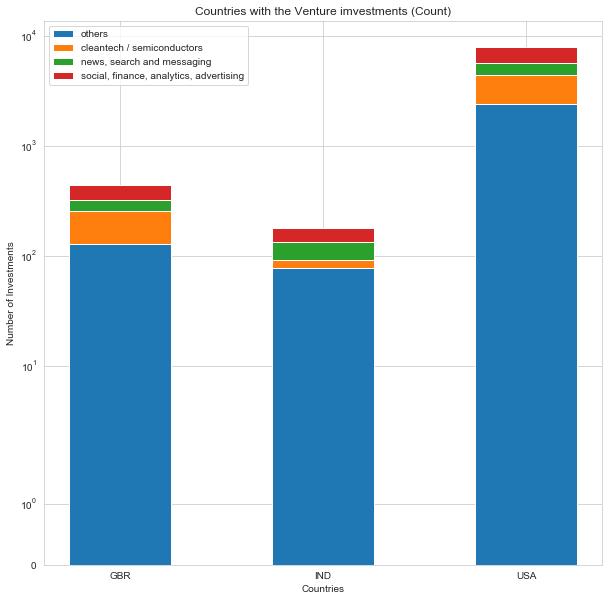

In [46]:
bar_width = 0.5
plt.figure(figsize=(10,10))
country_code = (lst_top3[1],lst_top3[2],lst_top3[0])

sector_1 = plt.bar(country_code, df_3country_sectors.count() \
                .loc[(df_3country_sectors.count()["main_sector"] == lst_sectors[1])]["raised_amount_Musd"] \
                , bar_width, label=lst_sectors[1])

sector_2 = plt.bar(country_code, df_3country_sectors.count()\
                .loc[(df_3country_sectors.count()["main_sector"] == lst_sectors[0])]["raised_amount_Musd"]\
                , bar_width,label=lst_sectors[0]\
                , bottom=df_3country_sectors.count()\
                .loc[(df_3country_sectors.count()["main_sector"] == lst_sectors[1])]\
                .groupby(['country_code']).sum()["raised_amount_Musd"])

sector_3 = plt.bar(country_code, df_3country_sectors.count()\
                .loc[(df_3country_sectors.count()["main_sector"] == lst_sectors[3])]["raised_amount_Musd"]\
                , bar_width,label=lst_sectors[3]\
                , bottom=df_3country_sectors.count()\
                .loc[ (df_3country_sectors.count()["main_sector"] == lst_sectors[1]) \
                        | (df_3country_sectors.count()["main_sector"] == lst_sectors[0])]\
                .groupby(['country_code']).sum()["raised_amount_Musd"])

sector_4 = plt.bar(country_code,df_3country_sectors.count()\
                .loc[(df_3country_sectors.count()["main_sector"] ==  lst_sectors[2])]["raised_amount_Musd"]\
                   , bar_width,label=lst_sectors[2]\
                   , bottom=df_3country_sectors.count()\
                   .loc[ (df_3country_sectors.count()["main_sector"] == lst_sectors[1]) \
                        | (df_3country_sectors.count()["main_sector"] == lst_sectors[0]) \
                        | (df_3country_sectors.count()["main_sector"] == lst_sectors[3])]\
                   .groupby(['country_code']).sum()["raised_amount_Musd"])

plt.title('Countries with the Venture imvestments (Count)')
plt.xlabel("Countries")
plt.ylabel("Number of Investments")
plt.yscale('symlog')
plt.legend()
plt.show()